# Logic-Enhanced Foundation Models (LEFT) in ~ 100 Lines

LEFT is a unified concept learning and reasoning framework that flexibly learns concepts across domains and reasons across unseen tasks.
This notebook demonstrates how to use LEFT to learn and reason about simple shapes in 2D images, with a very small amount of code.

In [1]:
import sys
sys.path.append("/home/max/uni/LEFT/Jacinle")

import torch
import jacinle
import numpy as np
import torch.nn as nn
import jactorch

from typing import Optional, Union, List, Dict
from jacinle.config.environ_v2 import configs, set_configs
from left.domain import create_domain_from_parsing
from left.models.model import LeftModel


### Step 1: Load the simple shapes dataset.

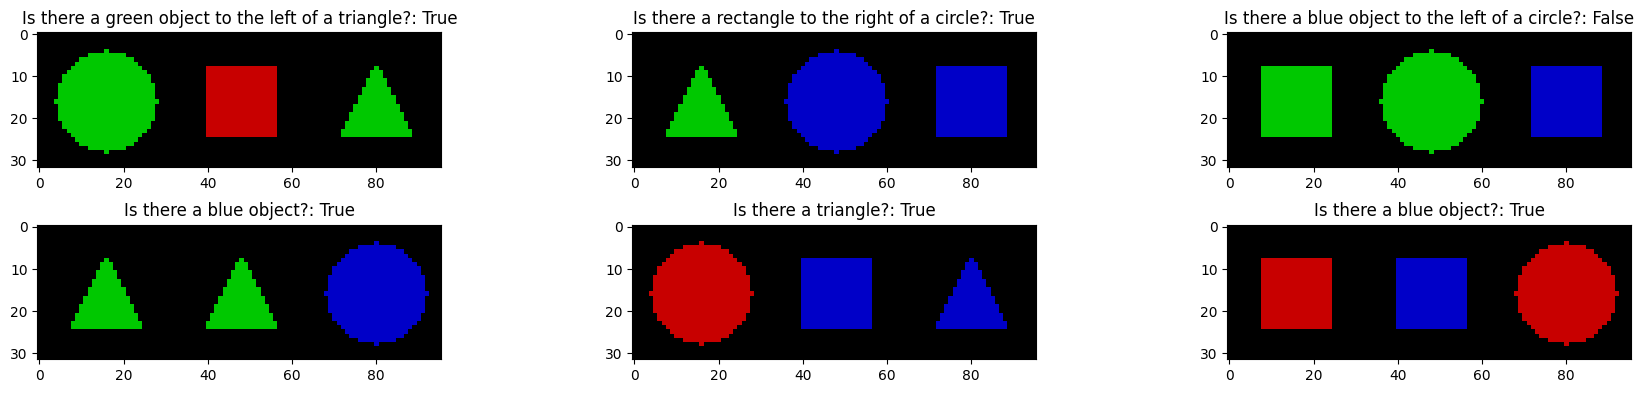

In [2]:
from concepts.benchmark.vision_language.shapes3.dataset import Shapes3Dataset
train_dataset = Shapes3Dataset(dataset_size=1024)  # create a dataset with 1024 samples
test_dataset = Shapes3Dataset(dataset_size=128)  # create a dataset with 128 samples for testing

# Now let's visualize a few samples from the dataset:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(train_dataset[i]['question'] + ': ' + str(train_dataset[i]['answer']))
plt.tight_layout()
plt.show()

### Step 2: Create the model.

Each model in LEFT is composed of:

- a visual feature extract that maps from images to a set of object features and their relational features.
- a concept embedding module that can classify objects and their relations into concepts. In this case, we will use a simple linear layer for all concepts.
- the program executor that takes a FOL program of the question as input, and generate the answer. This part is shared across all tasks, all domains, all modalities.

In [3]:
# Create the visual extractor. In this case, we will assume that we know each image is composed of three objects in a row.
# In general, we can use object detectors to extract the objects from the image.
# For each object, we will extract a 64-dimensional feature vector using a simple CNN.
# For each pair of objects, we will extract another 64-dimensional feature vector,
#   by using a simple lienar mapping from the concatenation of the two object features and their positional embeddings.

class ObjectCentricShapeEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.lenet = nn.Sequential(           # input is 1x32x32
            nn.Conv2d(3, 32, 5), nn.ReLU(),   # conv1: 32x28x28
            nn.MaxPool2d(2, 2),               # pool1: 32x14x14
            nn.Conv2d(32, 32, 5), nn.ReLU(),  # conv2: 32x10x10
            nn.MaxPool2d(2, 2),               # pool2: 32x5x5
        )
        self.fc = nn.Sequential(nn.Linear(32 * 5 * 5, 64), nn.ReLU())
        self.position_embedding = nn.Embedding(9, 64)
        self.fc2 = nn.Linear(256, 64)

    def forward(self, img):
        obj = self.forward_object(img)
        rel = self.forward_relation(obj)
        return obj, rel  # obj: [B, 3, 64], rel: [B, 3, 3, 64]

    def forward_object(self, img):
        # img = B, 3, 30, 30
        b = img.size(0)
        img = img.reshape((b, 3, 1, 32, 3, 32)).permute((0, 2, 4, 1, 3, 5)).reshape((b * 3, 3, 32, 32))
        img = self.lenet(img)
        img = img.reshape((b, 3, 32 * 25))
        img = self.fc(img)
        return img

    def forward_relation(self, object_feat):
        nr_objects = 3
        position_feature = torch.arange(nr_objects, dtype=torch.int64, device=object_feat.device)
        position_feature = self.position_embedding(position_feature)
        position_feature = position_feature.unsqueeze(0).expand(object_feat.size(0), nr_objects, 64)
        feature = torch.cat([object_feat, position_feature], dim=-1)

        feature1 = feature.unsqueeze(1).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature2 = feature.unsqueeze(2).expand(feature.size(0), nr_objects, nr_objects, 128)
        feature = torch.cat([feature1, feature2], dim=-1)

        feature = self.fc2(feature)
        return feature

In [4]:
# Create a main model. You just need to implement the object-centric feature extractor, and a few other lines of code to processs each question in the batch.

with set_configs():
    configs.model.domain = 'shapes3'            # set to the name of the dataset
    configs.model.scene_graph = None            # set to the identifier of the scene graph extractor. In this case we will use our own implementation.
    configs.model.concept_embedding = 'linear'  # set to the identifier of the concept embedding. In this case we will use a simple linear mapping.
    configs.model.sg_dims = [None, 64, 64, 64]  # set to the dimensions of the object and relation features. In this case we will use 64-dimensional features for all of them.


class SimpleShapesModel(LeftModel):
    def __init__(self, domain, parses: Dict[str, Union[str, List[str]]], output_vocab):
        super().__init__(domain, output_vocab)

        self.parses = parses
        self.scene_graph = ObjectCentricShapeEmbedding()

    def forward(self, feed_dict):
        feed_dict = jacinle.GView(feed_dict)
        monitors, outputs = {}, {}

        f_sng = self.forward_sng(feed_dict)
        for i in range(len(feed_dict.question)):
            grounding = self.grounding_cls(f_sng[i], self, self.training, apply_relation_mask=True)
            question = feed_dict.question[i]
            raw_parsing = self.parses[question]
            raw_parsing = raw_parsing[0] if isinstance(raw_parsing, list) else raw_parsing
            # This will write to outputs['executions']
            self.execute_program_from_parsing_string(question, raw_parsing, grounding, outputs)

        update_from_loss_module(monitors, outputs, self.qa_loss(outputs['executions'], feed_dict.answer, question_types=['bool' for _ in outputs['executions']]))

        if self.training:
            loss = monitors['loss/qa']
            return loss, monitors, outputs
        else:
            outputs['monitors'] = monitors
            return outputs

    def forward_sng(self, feed_dict):
        object_features, relation_features = self.scene_graph(feed_dict.image)
        all_scene_features = [{'attribute': object_features[i], 'relation': relation_features[i]} for i in range(len(object_features))]
        return all_scene_features


def update_from_loss_module(monitors, output_dict, loss_update):
    tmp_monitors, tmp_outputs = loss_update
    monitors.update(tmp_monitors)
    output_dict.update(tmp_outputs)

### Step 3: Training and evaluation.

In [5]:
language_to_program = {train_dataset[i]['question']: train_dataset[i]['program'] for i in range(len(train_dataset))}
language_to_program.update({test_dataset[i]['question']: test_dataset[i]['program'] for i in range(len(test_dataset))})

# In this example code, we will not be running GPT to parse the questions. Instead, we just use the groundtruth programs that come with the dataset.
# What you need is simple a dictionary that maps each question to its program.
# Visualize the first 6 questions and their programs.

for i in range(6):
    question = train_dataset[i]['question']
    print(question)
    print(language_to_program[question])

Is there a green object to the left of a triangle?
exists(Object, lambda x: exists(Object, lambda y: green(x) and left(x, y) and triangle(y)))
Is there a rectangle to the right of a circle?
exists(Object, lambda x: exists(Object, lambda y: rectangle(x) and right(x, y) and circle(y)))
Is there a blue object to the left of a circle?
exists(Object, lambda x: exists(Object, lambda y: blue(x) and left(x, y) and circle(y)))
Is there a blue object?
exists(Object, lambda x: blue(x))
Is there a triangle?
exists(Object, lambda x: triangle(x))
Is there a blue object?
exists(Object, lambda x: blue(x))


In [6]:
# Create a domain using all the parsed programs. It will automatically extract all concepts and relations from the programs.
domain = create_domain_from_parsing(language_to_program)

Creating domain from parsings: 100%|#############################################################################################################################################| 78/78 [00:00<00:00, 3781.75it/s]


In [7]:
# Visualize the domain. You can see that it has extracted all the concepts and relations from the programs.
domain.print_summary()

TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    green_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    triangle_Object(#0: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool
    circle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    red_Object(#0: Object) -> bool


In [8]:
# Define a helper function to update the meters.
def update_meters(meters, monitors, prefix: Optional[str] = None):
    for k in list(monitors.keys()):
        if k + '/n' in monitors:
            meters.update({k: monitors[k]}, n=monitors[k + '/n'], prefix=prefix)
            del monitors[k]
            del monitors[k + '/n']

    meters.update(monitors, prefix=prefix)

# Build the domain.
domain = create_domain_from_parsing(language_to_program)
domain.print_summary()

# Build the model.
model = SimpleShapesModel(domain, language_to_program, output_vocab=None)  # output vocab is not used (Boolean only)

# Build the optimizer.
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)
group_meters = jacinle.GroupMeters()

nr_epochs = 8
for i in range(1, nr_epochs + 1):
    dataloader = train_dataset.make_dataloader(batch_size=16, shuffle=True, drop_last=True, nr_workers=0)
    model.train()
    group_meters.reset()
    for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {}'.format(i)):
        loss, monitors, outputs = model(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_meters(group_meters, {k: float(v) for k, v in monitors.items()})
        jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i}', compressed=True))

    # print(group_meters.format_simple(f'Epoch {i}', compressed=False))

    dataloader = test_dataset.make_dataloader(batch_size=16, shuffle=False, drop_last=False, nr_workers=0)
    model.eval()
    group_meters.reset()
    with torch.no_grad():
        for data in jacinle.tqdm(dataloader, total=len(dataloader), desc='Epoch {} (test)'.format(i)):
            outputs = model(data)
            update_meters(group_meters, {k: float(v) for k, v in outputs['monitors'].items()})
            jacinle.get_current_tqdm().set_description(group_meters.format_simple(f'Epoch {i} (test)', compressed=True))

    print(group_meters.format_simple(f'Epoch {i} (test)', compressed=False))

Creating domain from parsings: 100%|#############################################################################################################################################| 78/78 [00:00<00:00, 5330.01it/s]
07 18:27:35 Function equal automatically registered.
07 18:27:35 Function greater_than automatically registered.
07 18:27:35 Function less_than automatically registered.


TypeSystem: Left
  Types:
    Object
    Object_Set
    Action
  Constants:
  Functions:
    equal(#0: int64, #1: int64) -> bool
    greater_than(#0: int64, #1: int64) -> bool
    less_than(#0: int64, #1: int64) -> bool
    green_Object(#0: Object) -> bool
    left_Object_Object(#0: Object, #1: Object) -> bool
    triangle_Object(#0: Object) -> bool
    rectangle_Object(#0: Object) -> bool
    right_Object_Object(#0: Object, #1: Object) -> bool
    circle_Object(#0: Object) -> bool
    blue_Object(#0: Object) -> bool
    red_Object(#0: Object) -> bool


Epoch 1 acc/qa=0.500000 acc/qa/bool=0.500000 acc/qa_succ_exec=0.500000 acc/success_exec=1.000000 loss/qa=0.712230:   5%|##8                                                         | 3/64 [00:00<00:02, 23.18it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 1 acc/qa=0.513889 acc/qa/bool=0.513889 acc/qa_succ_exec=0.513889 acc/success_exec=1.000000 loss/qa=0.684486:  14%|########4                                                   | 9/64 [00:00<00:02, 20.68it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUT

Epoch 1 acc/qa=0.514423 acc/qa/bool=0.514423 acc/qa_succ_exec=0.514423 acc/success_exec=1.000000 loss/qa=0.668810:  19%|###########                                                | 12/64 [00:00<00:02, 20.46it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 1 acc/qa=0.548611 acc/qa/bool=0.548611 acc/qa_succ_exec=0.548611 acc/success_exec=1.000000 loss/qa=0.652969:  27%|###############6                                           | 17/64 [00:00<00:02, 20.66it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 1 acc/qa=0.565341 acc/qa/bool=0.565341 acc/qa_succ_exec=0.565341 acc/success_exec=1.000000 loss/qa=0.631664:  33%|###################3                                       | 21/64 [00:01<00:02, 21.47it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 1 acc/qa=0.574074 acc/qa/bool=0.574074 acc/qa_succ_exec=0.574074 acc/success_exec=1.000000 loss/qa=0.632365:  42%|########################8                                  | 27/64 [00:01<00:01, 22.26it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 1 acc/qa=0.606855 acc/qa/bool=0.606855 acc/qa_succ_exec=0.606855 acc/success_exec=1.000000 loss/qa=0.620953:  47%|###########################6                               | 30/64 [00:01<00:01, 18.92it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 1 acc/qa=0.616319 acc/qa/bool=0.616319 acc/qa_succ_exec=0.616319 acc/success_exec=1.000000 loss/qa=0.618546:  55%|################################2                          | 35/64 [00:01<00:01, 19.08it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 1 acc/qa=0.620313 acc/qa/bool=0.620313 acc/qa_succ_exec=0.620313 acc/success_exec=1.000000 loss/qa=0.614716:  62%|####################################8                      | 40/64 [00:01<00:01, 19.74it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 1 acc/qa=0.620739 acc/qa/bool=0.620739 acc/qa_succ_exec=0.620739 acc/success_exec=1.000000 loss/qa=0.608078:  67%|#######################################6                   | 43/64 [00:02<00:01, 19.67it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - gr

Epoch 1 acc/qa=0.628827 acc/qa/bool=0.628827 acc/qa_succ_exec=0.628827 acc/success_exec=1.000000 loss/qa=0.601292:  75%|############################################2              | 48/64 [00:02<00:00, 21.21it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 

Epoch 1 acc/qa=0.640046 acc/qa/bool=0.640046 acc/qa_succ_exec=0.640046 acc/success_exec=1.000000 loss/qa=0.584236:  84%|#################################################7         | 54/64 [00:02<00:00, 21.79it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 1 acc/qa=0.654661 acc/qa/bool=0.654661 acc/qa_succ_exec=0.654661 acc/success_exec=1.000000 loss/qa=0.559908:  91%|#####################################################4     | 58/64 [00:02<00:00, 21.84it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 1 acc/qa=0.660714 acc/qa/bool=0.660714 acc/qa_succ_exec=0.660714 acc/success_exec=1.000000 loss/qa=0.547665:  98%|########################################################## | 63/64 [00:03<00:00, 21.46it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 1 acc/qa=0.664062 acc/qa/bool=0.664062 acc/qa_succ_exec=0.664062 acc/success_exec=1.000000 loss/qa=0.550704: 100%|###########################################################| 64/64 [00:03<00:00, 20.83it/s]
Epoch 1 (test) acc/qa=0.714286 acc/qa/bool=0.714286 acc/qa_succ_exec=0.714286 acc/success_exec=1.000000:  75%|#####################################################2                 | 6/8 [00:00<00:00, 36.77it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 1 (test) acc/qa=0.726562 acc/qa/bool=0.726562 acc/qa_succ_exec=0.726562 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 34.21it/s]


2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object

Epoch 2 acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/success_exec=1.000000 loss/qa=0.364252:   3%|#8                                                          | 2/64 [00:00<00:03, 16.08it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 2 acc/qa=0.791667 acc/qa/bool=0.791667 acc/qa_succ_exec=0.791667 acc/success_exec=1.000000 loss/qa=0.396145:   3%|#8                                                          | 2/64 [00:00<00:03, 16.08it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 2 acc/qa=0.785714 acc/qa/bool=0.785714 acc/qa_succ_exec=0.785714 acc/success_exec=1.000000 loss/qa=0.379407:  11%|######5                                                     | 7/64 [00:00<00:02, 19.06it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPU

Epoch 2 acc/qa=0.786458 acc/qa/bool=0.786458 acc/qa_succ_exec=0.786458 acc/success_exec=1.000000 loss/qa=0.368223:  17%|##########1                                                | 11/64 [00:00<00:02, 20.24it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 2 acc/qa=0.783654 acc/qa/bool=0.783654 acc/qa_succ_exec=0.783654 acc/success_exec=1.000000 loss/qa=0.369983:  20%|###########9                                               | 13/64 [00:00<00:02, 21.81it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 2 acc/qa=0.761719 acc/qa/bool=0.761719 acc/qa_succ_exec=0.761719 acc/success_exec=1.000000 loss/qa=0.385979:  25%|##############7                                            | 16/64 [00:00<00:02, 22.32it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 6

Epoch 2 acc/qa=0.764706 acc/qa/bool=0.764706 acc/qa_succ_exec=0.764706 acc/success_exec=1.000000 loss/qa=0.383927:  25%|##############7                                            | 16/64 [00:00<00:02, 22.32it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 2 acc/qa=0.755952 acc/qa/bool=0.755952 acc/qa_succ_exec=0.755952 acc/success_exec=1.000000 loss/qa=0.400617:  31%|##################4                                        | 20/64 [00:01<00:02, 21.45it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 2 acc/qa=0.761364 acc/qa/bool=0.761364 acc/qa_succ_exec=0.761364 acc/success_exec=1.000000 loss/qa=0.394216:  34%|####################2                                      | 22/64 [00:01<00:01, 21.10it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 2 acc/qa=0.755000 acc/qa/bool=0.755000 acc/qa_succ_exec=0.755000 acc/success_exec=1.000000 loss/qa=0.411557:  39%|#######################                                    | 25/64 [00:01<00:01, 21.81it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Objec

Epoch 2 acc/qa=0.759259 acc/qa/bool=0.759259 acc/qa_succ_exec=0.759259 acc/success_exec=1.000000 loss/qa=0.408182:  41%|#######################9                                   | 26/64 [00:01<00:01, 21.81it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 2 acc/qa=0.758065 acc/qa/bool=0.758065 acc/qa_succ_exec=0.758065 acc/success_exec=1.000000 loss/qa=0.407259:  48%|############################5                              | 31/64 [00:01<00:01, 22.95it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 6

Epoch 2 acc/qa=0.757812 acc/qa/bool=0.757812 acc/qa_succ_exec=0.757812 acc/success_exec=1.000000 loss/qa=0.410229:  48%|############################5                              | 31/64 [00:01<00:01, 22.95it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 2 acc/qa=0.764286 acc/qa/bool=0.764286 acc/qa_succ_exec=0.764286 acc/success_exec=1.000000 loss/qa=0.404812:  53%|###############################3                           | 34/64 [00:01<00:01, 23.27it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-S

Epoch 2 acc/qa=0.760417 acc/qa/bool=0.760417 acc/qa_succ_exec=0.760417 acc/success_exec=1.000000 loss/qa=0.409616:  55%|################################2                          | 35/64 [00:01<00:01, 23.27it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 2 acc/qa=0.768750 acc/qa/bool=0.768750 acc/qa_succ_exec=0.768750 acc/success_exec=1.000000 loss/qa=0.405985:  62%|####################################8                      | 40/64 [00:01<00:01, 22.86it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3

Epoch 2 acc/qa=0.769345 acc/qa/bool=0.769345 acc/qa_succ_exec=0.769345 acc/success_exec=1.000000 loss/qa=0.404652:  64%|#####################################7                     | 41/64 [00:01<00:01, 22.86it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 2 acc/qa=0.772727 acc/qa/bool=0.772727 acc/qa_succ_exec=0.772727 acc/success_exec=1.000000 loss/qa=0.403686:  67%|#######################################6                   | 43/64 [00:02<00:00, 23.11it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 2 acc/qa=0.772222 acc/qa/bool=0.772222 acc/qa_succ_exec=0.772222 acc/success_exec=1.000000 loss/qa=0.401956:  69%|########################################5                  | 44/64 [00:02<00:00, 23.11it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 2 acc/qa=0.769133 acc/qa/bool=0.769133 acc/qa_succ_exec=0.769133 acc/success_exec=1.000000 loss/qa=0.404048:  77%|#############################################1             | 49/64 [00:02<00:00, 20.94it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 2 acc/qa=0.770000 acc/qa/bool=0.770000 acc/qa_succ_exec=0.770000 acc/success_exec=1.000000 loss/qa=0.401197:  77%|#############################################1             | 49/64 [00:02<00:00, 20.94it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 2 acc/qa=0.775463 acc/qa/bool=0.775463 acc/qa_succ_exec=0.775463 acc/success_exec=1.000000 loss/qa=0.396445:  83%|################################################8          | 53/64 [00:02<00:00, 21.02it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 2 acc/qa=0.776136 acc/qa/bool=0.776136 acc/qa_succ_exec=0.776136 acc/success_exec=1.000000 loss/qa=0.396207:  86%|##################################################7        | 55/64 [00:02<00:00, 21.07it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 2 acc/qa=0.784958 acc/qa/bool=0.784958 acc/qa_succ_exec=0.784958 acc/success_exec=1.000000 loss/qa=0.386139:  91%|#####################################################4     | 58/64 [00:02<00:00, 21.64it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 2 acc/qa=0.786885 acc/qa/bool=0.786885 acc/qa_succ_exec=0.786885 acc/success_exec=1.000000 loss/qa=0.387046:  95%|########################################################2  | 61/64 [00:02<00:00, 22.51it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 2 acc/qa=0.791016 acc/qa/bool=0.791016 acc/qa_succ_exec=0.791016 acc/success_exec=1.000000 loss/qa=0.388402: 100%|###########################################################| 64/64 [00:02<00:00, 21.87it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 2 (test):   0%|                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 2 (test) acc/qa=0.916667 acc/qa/bool=0.916667 acc/qa_succ_exec=0.916667 acc/success_exec=1.000000:  25%|#################7                                                     | 2/8 [00:00<00:00, 25.61it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 2 (test) acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 37.93it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 2 (test) acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 37.73it/s]


Epoch 2 (test)
  acc/qa = 0.875000
  acc/qa/bool = 0.875000
  acc/qa_succ_exec = 0.875000
  acc/success_exec = 1.000000


Epoch 3 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.232813:   0%|                                                                    | 0/64 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-S

Epoch 3 acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000 loss/qa=0.306431:   5%|##8                                                         | 3/64 [00:00<00:02, 21.54it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-S

Epoch 3 acc/qa=0.864583 acc/qa/bool=0.864583 acc/qa_succ_exec=0.864583 acc/success_exec=1.000000 loss/qa=0.313909:   9%|#####6                                                      | 6/64 [00:00<00:02, 21.61it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 3 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000 loss/qa=0.308765:  11%|######5                                                     | 7/64 [00:00<00:02, 21.61it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 3 acc/qa=0.881944 acc/qa/bool=0.881944 acc/qa_succ_exec=0.881944 acc/success_exec=1.000000 loss/qa=0.303344:  14%|########4                                                   | 9/64 [00:00<00:02, 22.15it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 

Epoch 3 acc/qa=0.864583 acc/qa/bool=0.864583 acc/qa_succ_exec=0.864583 acc/success_exec=1.000000 loss/qa=0.294628:  19%|###########                                                | 12/64 [00:00<00:02, 23.45it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 3 acc/qa=0.857143 acc/qa/bool=0.857143 acc/qa_succ_exec=0.857143 acc/success_exec=1.000000 loss/qa=0.299392:  20%|###########9                                               | 13/64 [00:00<00:02, 23.45it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 3 acc/qa=0.858333 acc/qa/bool=0.858333 acc/qa_succ_exec=0.858333 acc/success_exec=1.000000 loss/qa=0.293638:  23%|#############8                                             | 15/64 [00:00<00:02, 23.34it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 3 acc/qa=0.860294 acc/qa/bool=0.860294 acc/qa_succ_exec=0.860294 acc/success_exec=1.000000 loss/qa=0.289824:  25%|##############7                                            | 16/64 [00:00<00:02, 23.34it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 3 acc/qa=0.861111 acc/qa/bool=0.861111 acc/qa_succ_exec=0.861111 acc/success_exec=1.000000 loss/qa=0.291243:  28%|################5                                          | 18/64 [00:00<00:01, 23.61it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 3 acc/qa=0.859375 acc/qa/bool=0.859375 acc/qa_succ_exec=0.859375 acc/success_exec=1.000000 loss/qa=0.291545:  30%|#################5                                         | 19/64 [00:00<00:01, 23.61it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]

Epoch 3 acc/qa=0.864130 acc/qa/bool=0.864130 acc/qa_succ_exec=0.864130 acc/success_exec=1.000000 loss/qa=0.288019:  34%|####################2                                      | 22/64 [00:01<00:02, 19.75it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 3 acc/qa=0.861979 acc/qa/bool=0.861979 acc/qa_succ_exec=0.861979 acc/success_exec=1.000000 loss/qa=0.293417:  38%|######################1                                    | 24/64 [00:01<00:01, 20.77it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3

Epoch 3 acc/qa=0.870536 acc/qa/bool=0.870536 acc/qa_succ_exec=0.870536 acc/success_exec=1.000000 loss/qa=0.281970:  42%|########################8                                  | 27/64 [00:01<00:01, 21.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPU

Epoch 3 acc/qa=0.872917 acc/qa/bool=0.872917 acc/qa_succ_exec=0.872917 acc/success_exec=1.000000 loss/qa=0.276525:  47%|###########################6                               | 30/64 [00:01<00:01, 22.62it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 3 acc/qa=0.882576 acc/qa/bool=0.882576 acc/qa_succ_exec=0.882576 acc/success_exec=1.000000 loss/qa=0.262121:  52%|##############################4                            | 33/64 [00:01<00:01, 23.67it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 3 acc/qa=0.885714 acc/qa/bool=0.885714 acc/qa_succ_exec=0.885714 acc/success_exec=1.000000 loss/qa=0.259820:  53%|###############################3                           | 34/64 [00:01<00:01, 23.67it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 3 acc/qa=0.889423 acc/qa/bool=0.889423 acc/qa_succ_exec=0.889423 acc/success_exec=1.000000 loss/qa=0.256395:  61%|###################################9                       | 39/64 [00:01<00:00, 25.35it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 3 acc/qa=0.891768 acc/qa/bool=0.891768 acc/qa_succ_exec=0.891768 acc/success_exec=1.000000 loss/qa=0.254614:  62%|####################################8                      | 40/64 [00:01<00:00, 25.35it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 3 acc/qa=0.893056 acc/qa/bool=0.893056 acc/qa_succ_exec=0.893056 acc/success_exec=1.000000 loss/qa=0.256627:  70%|#########################################4                 | 45/64 [00:01<00:00, 25.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 3 acc/qa=0.888298 acc/qa/bool=0.888298 acc/qa_succ_exec=0.888298 acc/success_exec=1.000000 loss/qa=0.269348:  72%|##########################################4                | 46/64 [00:02<00:00, 25.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 3 acc/qa=0.886480 acc/qa/bool=0.886480 acc/qa_succ_exec=0.886480 acc/success_exec=1.000000 loss/qa=0.270798:  75%|############################################2              | 48/64 [00:02<00:00, 24.88it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 3 acc/qa=0.888480 acc/qa/bool=0.888480 acc/qa_succ_exec=0.888480 acc/success_exec=1.000000 loss/qa=0.266910:  80%|###############################################            | 51/64 [00:02<00:00, 23.85it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 3 acc/qa=0.883102 acc/qa/bool=0.883102 acc/qa_succ_exec=0.883102 acc/success_exec=1.000000 loss/qa=0.272027:  84%|#################################################7         | 54/64 [00:02<00:00, 23.60it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 3 acc/qa=0.883929 acc/qa/bool=0.883929 acc/qa_succ_exec=0.883929 acc/success_exec=1.000000 loss/qa=0.280594:  86%|##################################################7        | 55/64 [00:02<00:00, 23.60it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 3 acc/qa=0.884534 acc/qa/bool=0.884534 acc/qa_succ_exec=0.884534 acc/success_exec=1.000000 loss/qa=0.289661:  91%|#####################################################4     | 58/64 [00:02<00:00, 22.60it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 3 acc/qa=0.886089 acc/qa/bool=0.886089 acc/qa_succ_exec=0.886089 acc/success_exec=1.000000 loss/qa=0.288687:  95%|########################################################2  | 61/64 [00:02<00:00, 23.19it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHA

Epoch 3 acc/qa=0.884766 acc/qa/bool=0.884766 acc/qa_succ_exec=0.884766 acc/success_exec=1.000000 loss/qa=0.289895: 100%|###########################################################| 64/64 [00:02<00:00, 23.28it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-S

Epoch 3 (test) acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000:  12%|########8                                                              | 1/8 [00:00<00:00, 24.97it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 3 (test) acc/qa=0.921875 acc/qa/bool=0.921875 acc/qa_succ_exec=0.921875 acc/success_exec=1.000000:  50%|###################################5                                   | 4/8 [00:00<00:00, 33.45it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 3 (test) acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000:  62%|############################################3                          | 5/8 [00:00<00:00, 33.45it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 3 (test) acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000:  75%|#####################################################2                 | 6/8 [00:00<00:00, 33.45it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 3 (test) acc/qa=0.882812 acc/qa/bool=0.882812 acc/qa_succ_exec=0.882812 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 30.88it/s]


2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.

Epoch 4 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000 loss/qa=0.310386:   2%|9                                                           | 1/64 [00:00<00:04, 12.83it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHA

Epoch 4 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/success_exec=1.000000 loss/qa=0.284181:   5%|##8                                                         | 3/64 [00:00<00:02, 25.59it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 4 acc/qa=0.921875 acc/qa/bool=0.921875 acc/qa_succ_exec=0.921875 acc/success_exec=1.000000 loss/qa=0.237438:   5%|##8                                                         | 3/64 [00:00<00:02, 25.59it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 4 acc/qa=0.919643 acc/qa/bool=0.919643 acc/qa_succ_exec=0.919643 acc/success_exec=1.000000 loss/qa=0.258018:   9%|#####6                                                      | 6/64 [00:00<00:02, 24.10it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 4 acc/qa=0.923611 acc/qa/bool=0.923611 acc/qa_succ_exec=0.923611 acc/success_exec=1.000000 loss/qa=0.246523:  14%|########4                                                   | 9/64 [00:00<00:02, 24.52it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 4 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000 loss/qa=0.267626:  14%|########4                                                   | 9/64 [00:00<00:02, 24.52it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 

Epoch 4 acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000 loss/qa=0.294220:  19%|###########                                                | 12/64 [00:00<00:02, 24.96it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_

Epoch 4 acc/qa=0.883929 acc/qa/bool=0.883929 acc/qa_succ_exec=0.883929 acc/success_exec=1.000000 loss/qa=0.299261:  20%|###########9                                               | 13/64 [00:00<00:02, 24.96it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 4 acc/qa=0.883333 acc/qa/bool=0.883333 acc/qa_succ_exec=0.883333 acc/success_exec=1.000000 loss/qa=0.297934:  23%|#############8                                             | 15/64 [00:00<00:01, 25.22it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUT

Epoch 4 acc/qa=0.893382 acc/qa/bool=0.893382 acc/qa_succ_exec=0.893382 acc/success_exec=1.000000 loss/qa=0.285583:  25%|##############7                                            | 16/64 [00:00<00:01, 25.22it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object

Epoch 4 acc/qa=0.892361 acc/qa/bool=0.892361 acc/qa_succ_exec=0.892361 acc/success_exec=1.000000 loss/qa=0.292161:  28%|################5                                          | 18/64 [00:00<00:01, 23.88it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 4 acc/qa=0.894737 acc/qa/bool=0.894737 acc/qa_succ_exec=0.894737 acc/success_exec=1.000000 loss/qa=0.287088:  28%|################5                                          | 18/64 [00:00<00:01, 23.88it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 4 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/success_exec=1.000000 loss/qa=0.281124:  33%|###################3                                       | 21/64 [00:00<00:01, 22.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 4 acc/qa=0.896739 acc/qa/bool=0.896739 acc/qa_succ_exec=0.896739 acc/success_exec=1.000000 loss/qa=0.282089:  34%|####################2                                      | 22/64 [00:00<00:01, 22.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 4 acc/qa=0.900000 acc/qa/bool=0.900000 acc/qa_succ_exec=0.900000 acc/success_exec=1.000000 loss/qa=0.273179:  38%|######################1                                    | 24/64 [00:01<00:01, 20.77it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 4 acc/qa=0.902778 acc/qa/bool=0.902778 acc/qa_succ_exec=0.902778 acc/success_exec=1.000000 loss/qa=0.277767:  42%|########################8                                  | 27/64 [00:01<00:01, 21.18it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 4 acc/qa=0.904018 acc/qa/bool=0.904018 acc/qa_succ_exec=0.904018 acc/success_exec=1.000000 loss/qa=0.276319:  42%|########################8                                  | 27/64 [00:01<00:01, 21.18it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 4 acc/qa=0.900862 acc/qa/bool=0.900862 acc/qa_succ_exec=0.900862 acc/success_exec=1.000000 loss/qa=0.285714:  44%|#########################8                                 | 28/64 [00:01<00:01, 21.18it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([

Epoch 4 acc/qa=0.903226 acc/qa/bool=0.903226 acc/qa_succ_exec=0.903226 acc/success_exec=1.000000 loss/qa=0.282852:  47%|###########################6                               | 30/64 [00:01<00:01, 21.35it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUT

Epoch 4 acc/qa=0.897727 acc/qa/bool=0.897727 acc/qa_succ_exec=0.897727 acc/success_exec=1.000000 loss/qa=0.287867:  52%|##############################4                            | 33/64 [00:01<00:01, 21.44it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3

Epoch 4 acc/qa=0.900735 acc/qa/bool=0.900735 acc/qa_succ_exec=0.900735 acc/success_exec=1.000000 loss/qa=0.284793:  52%|##############################4                            | 33/64 [00:01<00:01, 21.44it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 4 acc/qa=0.901042 acc/qa/bool=0.901042 acc/qa_succ_exec=0.901042 acc/success_exec=1.000000 loss/qa=0.282541:  56%|#################################1                         | 36/64 [00:01<00:01, 21.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-S

Epoch 4 acc/qa=0.901316 acc/qa/bool=0.901316 acc/qa_succ_exec=0.901316 acc/success_exec=1.000000 loss/qa=0.280948:  58%|##################################1                        | 37/64 [00:01<00:01, 21.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 

Epoch 4 acc/qa=0.904687 acc/qa/bool=0.904687 acc/qa_succ_exec=0.904687 acc/success_exec=1.000000 loss/qa=0.272668:  61%|###################################9                       | 39/64 [00:01<00:01, 21.94it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 4 acc/qa=0.905488 acc/qa/bool=0.905488 acc/qa_succ_exec=0.905488 acc/success_exec=1.000000 loss/qa=0.270094:  62%|####################################8                      | 40/64 [00:01<00:01, 21.94it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 4 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000 loss/qa=0.266809:  66%|######################################7                    | 42/64 [00:01<00:01, 20.01it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 6

Epoch 4 acc/qa=0.908430 acc/qa/bool=0.908430 acc/qa_succ_exec=0.908430 acc/success_exec=1.000000 loss/qa=0.261677:  66%|######################################7                    | 42/64 [00:01<00:01, 20.01it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 4 acc/qa=0.909722 acc/qa/bool=0.909722 acc/qa_succ_exec=0.909722 acc/success_exec=1.000000 loss/qa=0.258366:  70%|#########################################4                 | 45/64 [00:02<00:00, 20.78it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 4 acc/qa=0.908854 acc/qa/bool=0.908854 acc/qa_succ_exec=0.908854 acc/success_exec=1.000000 loss/qa=0.256231:  75%|############################################2              | 48/64 [00:02<00:00, 21.67it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 4 acc/qa=0.908088 acc/qa/bool=0.908088 acc/qa_succ_exec=0.908088 acc/success_exec=1.000000 loss/qa=0.253583:  80%|###############################################            | 51/64 [00:02<00:00, 22.39it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 6

Epoch 4 acc/qa=0.906840 acc/qa/bool=0.906840 acc/qa_succ_exec=0.906840 acc/success_exec=1.000000 loss/qa=0.257942:  81%|###############################################9           | 52/64 [00:02<00:00, 22.39it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]

Epoch 4 acc/qa=0.908565 acc/qa/bool=0.908565 acc/qa_succ_exec=0.908565 acc/success_exec=1.000000 loss/qa=0.254316:  84%|#################################################7         | 54/64 [00:02<00:00, 23.67it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAP

Epoch 4 acc/qa=0.909598 acc/qa/bool=0.909598 acc/qa_succ_exec=0.909598 acc/success_exec=1.000000 loss/qa=0.249962:  86%|##################################################7        | 55/64 [00:02<00:00, 23.67it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 4 acc/qa=0.908405 acc/qa/bool=0.908405 acc/qa_succ_exec=0.908405 acc/success_exec=1.000000 loss/qa=0.248658:  89%|####################################################5      | 57/64 [00:02<00:00, 24.69it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 4 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000 loss/qa=0.251198:  94%|#######################################################3   | 60/64 [00:02<00:00, 25.04it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 4 acc/qa=0.907258 acc/qa/bool=0.907258 acc/qa_succ_exec=0.907258 acc/success_exec=1.000000 loss/qa=0.252155:  95%|########################################################2  | 61/64 [00:02<00:00, 25.04it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 4 acc/qa=0.908203 acc/qa/bool=0.908203 acc/qa_succ_exec=0.908203 acc/success_exec=1.000000 loss/qa=0.249861: 100%|###########################################################| 64/64 [00:02<00:00, 22.87it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 4 (test) acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000:  12%|########8                                                              | 1/8 [00:00<00:00, 23.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 4 (test) acc/qa=0.900000 acc/qa/bool=0.900000 acc/qa_succ_exec=0.900000 acc/success_exec=1.000000:  62%|############################################3                          | 5/8 [00:00<00:00, 43.82it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 4 (test) acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 42.47it/s]


2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - to

Epoch 5:   0%|                                                                                                                                                                              | 0/64 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 5 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.019033:   0%|                                                                    | 0/64 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 5 acc/qa=0.979167 acc/qa/bool=0.979167 acc/qa_succ_exec=0.979167 acc/success_exec=1.000000 loss/qa=0.135681:   5%|##8                                                         | 3/64 [00:00<00:02, 28.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 5 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.169464:   6%|###7                                                        | 4/64 [00:00<00:02, 28.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 

Epoch 5 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.207528:   9%|#####6                                                      | 6/64 [00:00<00:02, 25.69it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 5 acc/qa=0.929688 acc/qa/bool=0.929688 acc/qa_succ_exec=0.929688 acc/success_exec=1.000000 loss/qa=0.200994:  11%|######5                                                     | 7/64 [00:00<00:02, 25.69it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 5 acc/qa=0.918750 acc/qa/bool=0.918750 acc/qa_succ_exec=0.918750 acc/success_exec=1.000000 loss/qa=0.212923:  14%|########4                                                   | 9/64 [00:00<00:02, 23.84it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size(

Epoch 5 acc/qa=0.909091 acc/qa/bool=0.909091 acc/qa_succ_exec=0.909091 acc/success_exec=1.000000 loss/qa=0.218363:  16%|#########2                                                 | 10/64 [00:00<00:02, 23.84it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-

Epoch 5 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000 loss/qa=0.235038:  20%|###########9                                               | 13/64 [00:00<00:02, 23.76it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT

Epoch 5 acc/qa=0.904167 acc/qa/bool=0.904167 acc/qa_succ_exec=0.904167 acc/success_exec=1.000000 loss/qa=0.253849:  23%|#############8                                             | 15/64 [00:00<00:02, 23.36it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 5 acc/qa=0.898438 acc/qa/bool=0.898438 acc/qa_succ_exec=0.898438 acc/success_exec=1.000000 loss/qa=0.256948:  23%|#############8                                             | 15/64 [00:00<00:02, 23.36it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 5 acc/qa=0.888158 acc/qa/bool=0.888158 acc/qa_succ_exec=0.888158 acc/success_exec=1.000000 loss/qa=0.254236:  28%|################5                                          | 18/64 [00:00<00:01, 23.63it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 5 acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000 loss/qa=0.255356:  30%|#################5                                         | 19/64 [00:00<00:01, 23.63it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPU

Epoch 5 acc/qa=0.886905 acc/qa/bool=0.886905 acc/qa_succ_exec=0.886905 acc/success_exec=1.000000 loss/qa=0.261117:  33%|###################3                                       | 21/64 [00:00<00:02, 21.31it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 5 acc/qa=0.889205 acc/qa/bool=0.889205 acc/qa_succ_exec=0.889205 acc/success_exec=1.000000 loss/qa=0.258420:  33%|###################3                                       | 21/64 [00:00<00:02, 21.31it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 5 acc/qa=0.888021 acc/qa/bool=0.888021 acc/qa_succ_exec=0.888021 acc/success_exec=1.000000 loss/qa=0.253477:  38%|######################1                                    | 24/64 [00:01<00:01, 21.34it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 5 acc/qa=0.890000 acc/qa/bool=0.890000 acc/qa_succ_exec=0.890000 acc/success_exec=1.000000 loss/qa=0.248580:  38%|######################1                                    | 24/64 [00:01<00:01, 21.34it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 5 acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000 loss/qa=0.253931:  42%|########################8                                  | 27/64 [00:01<00:01, 22.42it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPU

Epoch 5 acc/qa=0.889583 acc/qa/bool=0.889583 acc/qa_succ_exec=0.889583 acc/success_exec=1.000000 loss/qa=0.259301:  47%|###########################6                               | 30/64 [00:01<00:01, 22.83it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3

Epoch 5 acc/qa=0.886719 acc/qa/bool=0.886719 acc/qa_succ_exec=0.886719 acc/success_exec=1.000000 loss/qa=0.260864:  48%|############################5                              | 31/64 [00:01<00:01, 22.83it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 5 acc/qa=0.886029 acc/qa/bool=0.886029 acc/qa_succ_exec=0.886029 acc/success_exec=1.000000 loss/qa=0.266910:  52%|##############################4                            | 33/64 [00:01<00:01, 22.24it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64

Epoch 5 acc/qa=0.887500 acc/qa/bool=0.887500 acc/qa_succ_exec=0.887500 acc/success_exec=1.000000 loss/qa=0.266681:  53%|###############################3                           | 34/64 [00:01<00:01, 22.24it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 5 acc/qa=0.888514 acc/qa/bool=0.888514 acc/qa_succ_exec=0.888514 acc/success_exec=1.000000 loss/qa=0.269280:  56%|#################################1                         | 36/64 [00:01<00:01, 22.41it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 5 acc/qa=0.894231 acc/qa/bool=0.894231 acc/qa_succ_exec=0.894231 acc/success_exec=1.000000 loss/qa=0.263525:  61%|###################################9                       | 39/64 [00:01<00:01, 22.00it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 5 acc/qa=0.893750 acc/qa/bool=0.893750 acc/qa_succ_exec=0.893750 acc/success_exec=1.000000 loss/qa=0.264014:  61%|###################################9                       | 39/64 [00:01<00:01, 22.00it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 5 acc/qa=0.895349 acc/qa/bool=0.895349 acc/qa_succ_exec=0.895349 acc/success_exec=1.000000 loss/qa=0.259528:  66%|######################################7                    | 42/64 [00:01<00:00, 23.08it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3,

Epoch 5 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/success_exec=1.000000 loss/qa=0.258700:  70%|#########################################4                 | 45/64 [00:01<00:00, 23.35it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle

Epoch 5 acc/qa=0.896739 acc/qa/bool=0.896739 acc/qa_succ_exec=0.896739 acc/success_exec=1.000000 loss/qa=0.256579:  70%|#########################################4                 | 45/64 [00:02<00:00, 23.35it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUT

Epoch 5 acc/qa=0.898936 acc/qa/bool=0.898936 acc/qa_succ_exec=0.898936 acc/success_exec=1.000000 loss/qa=0.252819:  72%|##########################################4                | 46/64 [00:02<00:00, 23.35it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 5 acc/qa=0.900000 acc/qa/bool=0.900000 acc/qa_succ_exec=0.900000 acc/success_exec=1.000000 loss/qa=0.255011:  77%|#############################################1             | 49/64 [00:02<00:00, 23.29it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 5 acc/qa=0.901961 acc/qa/bool=0.901961 acc/qa_succ_exec=0.901961 acc/success_exec=1.000000 loss/qa=0.251672:  80%|###############################################            | 51/64 [00:02<00:00, 23.70it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) |

Epoch 5 acc/qa=0.902123 acc/qa/bool=0.902123 acc/qa_succ_exec=0.902123 acc/success_exec=1.000000 loss/qa=0.250031:  81%|###############################################9           | 52/64 [00:02<00:00, 23.70it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 5 acc/qa=0.903409 acc/qa/bool=0.903409 acc/qa_succ_exec=0.903409 acc/success_exec=1.000000 loss/qa=0.249777:  84%|#################################################7         | 54/64 [00:02<00:00, 24.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 5 acc/qa=0.901786 acc/qa/bool=0.901786 acc/qa_succ_exec=0.901786 acc/success_exec=1.000000 loss/qa=0.253804:  86%|##################################################7        | 55/64 [00:02<00:00, 24.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 5 acc/qa=0.903017 acc/qa/bool=0.903017 acc/qa_succ_exec=0.903017 acc/success_exec=1.000000 loss/qa=0.253494:  89%|####################################################5      | 57/64 [00:02<00:00, 24.00it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triang

Epoch 5 acc/qa=0.904167 acc/qa/bool=0.904167 acc/qa_succ_exec=0.904167 acc/success_exec=1.000000 loss/qa=0.251591:  94%|#######################################################3   | 60/64 [00:02<00:00, 24.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 5 acc/qa=0.903689 acc/qa/bool=0.903689 acc/qa_succ_exec=0.903689 acc/success_exec=1.000000 loss/qa=0.252171:  94%|#######################################################3   | 60/64 [00:02<00:00, 24.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 5 acc/qa=0.901786 acc/qa/bool=0.901786 acc/qa_succ_exec=0.901786 acc/success_exec=1.000000 loss/qa=0.255906:  98%|########################################################## | 63/64 [00:02<00:00, 24.17it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 

Epoch 5 acc/qa=0.903320 acc/qa/bool=0.903320 acc/qa_succ_exec=0.903320 acc/success_exec=1.000000 loss/qa=0.254044: 100%|###########################################################| 64/64 [00:02<00:00, 23.31it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 5 (test) acc/qa=0.812500 acc/qa/bool=0.812500 acc/qa_succ_exec=0.812500 acc/success_exec=1.000000:   0%|                                                                               | 0/8 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 5 (test) acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000:  12%|########8                                                              | 1/8 [00:00<00:00, 17.99it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Obj

Epoch 5 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000:  50%|###################################5                                   | 4/8 [00:00<00:00, 26.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 5 (test) acc/qa=0.900000 acc/qa/bool=0.900000 acc/qa_succ_exec=0.900000 acc/success_exec=1.000000:  50%|###################################5                                   | 4/8 [00:00<00:00, 26.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 5 (test) acc/qa=0.883929 acc/qa/bool=0.883929 acc/qa_succ_exec=0.883929 acc/success_exec=1.000000:  88%|##############################################################1        | 7/8 [00:00<00:00, 25.08it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 5 (test) acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 26.46it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 6 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.193465:   0%|                                                                    | 0/64 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 6 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.201559:   2%|9                                                           | 1/64 [00:00<00:04, 12.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 

Epoch 6 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.212328:   5%|##8                                                         | 3/64 [00:00<00:02, 25.96it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTP

Epoch 6 acc/qa=0.921875 acc/qa/bool=0.921875 acc/qa_succ_exec=0.921875 acc/success_exec=1.000000 loss/qa=0.225007:   5%|##8                                                         | 3/64 [00:00<00:02, 25.96it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 6 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000 loss/qa=0.325527:   6%|###7                                                        | 4/64 [00:00<00:02, 25.96it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 6 acc/qa=0.892857 acc/qa/bool=0.892857 acc/qa_succ_exec=0.892857 acc/success_exec=1.000000 loss/qa=0.289353:   9%|#####6                                                      | 6/64 [00:00<00:02, 24.85it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 6 acc/qa=0.898438 acc/qa/bool=0.898438 acc/qa_succ_exec=0.898438 acc/success_exec=1.000000 loss/qa=0.271497:  11%|######5                                                     | 7/64 [00:00<00:02, 24.85it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 6 acc/qa=0.909722 acc/qa/bool=0.909722 acc/qa_succ_exec=0.909722 acc/success_exec=1.000000 loss/qa=0.260808:  14%|########4                                                   | 9/64 [00:00<00:02, 23.73it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 6 acc/qa=0.920455 acc/qa/bool=0.920455 acc/qa_succ_exec=0.920455 acc/success_exec=1.000000 loss/qa=0.250858:  16%|#########2                                                 | 10/64 [00:00<00:02, 23.73it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-S

Epoch 6 acc/qa=0.927885 acc/qa/bool=0.927885 acc/qa_succ_exec=0.927885 acc/success_exec=1.000000 loss/qa=0.239495:  19%|###########                                                | 12/64 [00:00<00:02, 23.84it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 6 acc/qa=0.928571 acc/qa/bool=0.928571 acc/qa_succ_exec=0.928571 acc/success_exec=1.000000 loss/qa=0.234453:  20%|###########9                                               | 13/64 [00:00<00:02, 23.84it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 6 acc/qa=0.929167 acc/qa/bool=0.929167 acc/qa_succ_exec=0.929167 acc/success_exec=1.000000 loss/qa=0.227629:  23%|#############8                                             | 15/64 [00:00<00:01, 24.57it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUT

Epoch 6 acc/qa=0.922794 acc/qa/bool=0.922794 acc/qa_succ_exec=0.922794 acc/success_exec=1.000000 loss/qa=0.244942:  25%|##############7                                            | 16/64 [00:00<00:01, 24.57it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 6 acc/qa=0.916667 acc/qa/bool=0.916667 acc/qa_succ_exec=0.916667 acc/success_exec=1.000000 loss/qa=0.248251:  28%|################5                                          | 18/64 [00:00<00:01, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 6 acc/qa=0.917763 acc/qa/bool=0.917763 acc/qa_succ_exec=0.917763 acc/success_exec=1.000000 loss/qa=0.241569:  28%|################5                                          | 18/64 [00:00<00:01, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 

Epoch 6 acc/qa=0.918750 acc/qa/bool=0.918750 acc/qa_succ_exec=0.918750 acc/success_exec=1.000000 loss/qa=0.236042:  30%|#################5                                         | 19/64 [00:00<00:01, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 6

Epoch 6 acc/qa=0.920455 acc/qa/bool=0.920455 acc/qa_succ_exec=0.920455 acc/success_exec=1.000000 loss/qa=0.237653:  33%|###################3                                       | 21/64 [00:00<00:01, 24.89it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - 

Epoch 6 acc/qa=0.913043 acc/qa/bool=0.913043 acc/qa_succ_exec=0.913043 acc/success_exec=1.000000 loss/qa=0.244434:  34%|####################2                                      | 22/64 [00:00<00:01, 24.89it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_

Epoch 6 acc/qa=0.908854 acc/qa/bool=0.908854 acc/qa_succ_exec=0.908854 acc/success_exec=1.000000 loss/qa=0.248058:  38%|######################1                                    | 24/64 [00:00<00:01, 24.63it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 6 acc/qa=0.910000 acc/qa/bool=0.910000 acc/qa_succ_exec=0.910000 acc/success_exec=1.000000 loss/qa=0.246709:  38%|######################1                                    | 24/64 [00:01<00:01, 24.63it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3

Epoch 6 acc/qa=0.914352 acc/qa/bool=0.914352 acc/qa_succ_exec=0.914352 acc/success_exec=1.000000 loss/qa=0.235335:  42%|########################8                                  | 27/64 [00:01<00:01, 24.60it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 6 acc/qa=0.912946 acc/qa/bool=0.912946 acc/qa_succ_exec=0.912946 acc/success_exec=1.000000 loss/qa=0.235273:  42%|########################8                                  | 27/64 [00:01<00:01, 24.60it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 6 acc/qa=0.913793 acc/qa/bool=0.913793 acc/qa_succ_exec=0.913793 acc/success_exec=1.000000 loss/qa=0.237559:  44%|#########################8                                 | 28/64 [00:01<00:01, 24.60it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-

Epoch 6 acc/qa=0.910417 acc/qa/bool=0.910417 acc/qa_succ_exec=0.910417 acc/success_exec=1.000000 loss/qa=0.238016:  47%|###########################6                               | 30/64 [00:01<00:01, 24.29it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 6 acc/qa=0.904297 acc/qa/bool=0.904297 acc/qa_succ_exec=0.904297 acc/success_exec=1.000000 loss/qa=0.242363:  48%|############################5                              | 31/64 [00:01<00:01, 24.29it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3

Epoch 6 acc/qa=0.901515 acc/qa/bool=0.901515 acc/qa_succ_exec=0.901515 acc/success_exec=1.000000 loss/qa=0.244963:  52%|##############################4                            | 33/64 [00:01<00:01, 24.16it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 6 acc/qa=0.901786 acc/qa/bool=0.901786 acc/qa_succ_exec=0.901786 acc/success_exec=1.000000 loss/qa=0.241913:  53%|###############################3                           | 34/64 [00:01<00:01, 24.16it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 6 acc/qa=0.900338 acc/qa/bool=0.900338 acc/qa_succ_exec=0.900338 acc/success_exec=1.000000 loss/qa=0.250130:  56%|#################################1                         | 36/64 [00:01<00:01, 24.42it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 6 acc/qa=0.898026 acc/qa/bool=0.898026 acc/qa_succ_exec=0.898026 acc/success_exec=1.000000 loss/qa=0.253651:  58%|##################################1                        | 37/64 [00:01<00:01, 24.42it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 6 acc/qa=0.897436 acc/qa/bool=0.897436 acc/qa_succ_exec=0.897436 acc/success_exec=1.000000 loss/qa=0.252297:  61%|###################################9                       | 39/64 [00:01<00:01, 24.02it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 6 acc/qa=0.896875 acc/qa/bool=0.896875 acc/qa_succ_exec=0.896875 acc/success_exec=1.000000 loss/qa=0.258572:  61%|###################################9                       | 39/64 [00:01<00:01, 24.02it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 6 acc/qa=0.897321 acc/qa/bool=0.897321 acc/qa_succ_exec=0.897321 acc/success_exec=1.000000 loss/qa=0.259353:  66%|######################################7                    | 42/64 [00:01<00:00, 24.51it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 6 acc/qa=0.896802 acc/qa/bool=0.896802 acc/qa_succ_exec=0.896802 acc/success_exec=1.000000 loss/qa=0.259926:  66%|######################################7                    | 42/64 [00:01<00:00, 24.51it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 6 acc/qa=0.899148 acc/qa/bool=0.899148 acc/qa_succ_exec=0.899148 acc/success_exec=1.000000 loss/qa=0.256300:  67%|#######################################6                   | 43/64 [00:01<00:00, 24.51it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])

Epoch 6 acc/qa=0.898611 acc/qa/bool=0.898611 acc/qa_succ_exec=0.898611 acc/success_exec=1.000000 loss/qa=0.255107:  70%|#########################################4                 | 45/64 [00:01<00:00, 20.92it/s]


{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object

Epoch 6 acc/qa=0.895380 acc/qa/bool=0.895380 acc/qa_succ_exec=0.895380 acc/success_exec=1.000000 loss/qa=0.260482:  70%|#########################################4                 | 45/64 [00:01<00:00, 20.92it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHA

Epoch 6 acc/qa=0.897135 acc/qa/bool=0.897135 acc/qa_succ_exec=0.897135 acc/success_exec=1.000000 loss/qa=0.256212:  75%|############################################2              | 48/64 [00:02<00:00, 21.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 6 acc/qa=0.897500 acc/qa/bool=0.897500 acc/qa_succ_exec=0.897500 acc/success_exec=1.000000 loss/qa=0.254611:  77%|#############################################1             | 49/64 [00:02<00:00, 21.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 6 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/success_exec=1.000000 loss/qa=0.254709:  80%|###############################################            | 51/64 [00:02<00:00, 22.03it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 6 acc/qa=0.896226 acc/qa/bool=0.896226 acc/qa_succ_exec=0.896226 acc/success_exec=1.000000 loss/qa=0.254869:  81%|###############################################9           | 52/64 [00:02<00:00, 22.03it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 6 acc/qa=0.895455 acc/qa/bool=0.895455 acc/qa_succ_exec=0.895455 acc/success_exec=1.000000 loss/qa=0.256715:  84%|#################################################7         | 54/64 [00:02<00:00, 22.74it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 6 acc/qa=0.893973 acc/qa/bool=0.893973 acc/qa_succ_exec=0.893973 acc/success_exec=1.000000 loss/qa=0.256618:  86%|##################################################7        | 55/64 [00:02<00:00, 22.74it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 6 acc/qa=0.889009 acc/qa/bool=0.889009 acc/qa_succ_exec=0.889009 acc/success_exec=1.000000 loss/qa=0.262518:  89%|####################################################5      | 57/64 [00:02<00:00, 23.82it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Obje

Epoch 6 acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000 loss/qa=0.261496:  94%|#######################################################3   | 60/64 [00:02<00:00, 23.99it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Obj

Epoch 6 acc/qa=0.888320 acc/qa/bool=0.888320 acc/qa_succ_exec=0.888320 acc/success_exec=1.000000 loss/qa=0.267323:  94%|#######################################################3   | 60/64 [00:02<00:00, 23.99it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 6 acc/qa=0.887897 acc/qa/bool=0.887897 acc/qa_succ_exec=0.887897 acc/success_exec=1.000000 loss/qa=0.267758:  98%|########################################################## | 63/64 [00:02<00:00, 24.76it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 6 acc/qa=0.888672 acc/qa/bool=0.888672 acc/qa_succ_exec=0.888672 acc/success_exec=1.000000 loss/qa=0.266279: 100%|###########################################################| 64/64 [00:02<00:00, 23.92it/s]
Epoch 6 (test) acc/qa=0.916667 acc/qa/bool=0.916667 acc/qa_succ_exec=0.916667 acc/success_exec=1.000000:  25%|#################7                                                     | 2/8 [00:00<00:00, 33.76it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 6 (test) acc/qa=0.862500 acc/qa/bool=0.862500 acc/qa_succ_exec=0.862500 acc/success_exec=1.000000:  62%|############################################3                          | 5/8 [00:00<00:00, 48.30it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 6 (test) acc/qa=0.843750 acc/qa/bool=0.843750 acc/qa_succ_exec=0.843750 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 45.78it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 7:   0%|                                                                                                                                                                              | 0/64 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 

Epoch 7 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.332992:   2%|9                                                           | 1/64 [00:00<00:04, 12.73it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 7 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/success_exec=1.000000 loss/qa=0.332577:   5%|##8                                                         | 3/64 [00:00<00:02, 25.76it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 6

Epoch 7 acc/qa=0.875000 acc/qa/bool=0.875000 acc/qa_succ_exec=0.875000 acc/success_exec=1.000000 loss/qa=0.306592:   6%|###7                                                        | 4/64 [00:00<00:02, 25.76it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 7 acc/qa=0.895833 acc/qa/bool=0.895833 acc/qa_succ_exec=0.895833 acc/success_exec=1.000000 loss/qa=0.286308:   9%|#####6                                                      | 6/64 [00:00<00:02, 24.71it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object -

Epoch 7 acc/qa=0.910714 acc/qa/bool=0.910714 acc/qa_succ_exec=0.910714 acc/success_exec=1.000000 loss/qa=0.260218:   9%|#####6                                                      | 6/64 [00:00<00:02, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 7 acc/qa=0.923611 acc/qa/bool=0.923611 acc/qa_succ_exec=0.923611 acc/success_exec=1.000000 loss/qa=0.242412:  14%|########4                                                   | 9/64 [00:00<00:02, 25.22it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Obj

Epoch 7 acc/qa=0.931250 acc/qa/bool=0.931250 acc/qa_succ_exec=0.931250 acc/success_exec=1.000000 loss/qa=0.223993:  14%|########4                                                   | 9/64 [00:00<00:02, 25.22it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUT

Epoch 7 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.211760:  16%|#########2                                                 | 10/64 [00:00<00:02, 25.22it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 7 acc/qa=0.932292 acc/qa/bool=0.932292 acc/qa_succ_exec=0.932292 acc/success_exec=1.000000 loss/qa=0.215443:  19%|###########                                                | 12/64 [00:00<00:02, 25.98it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 7 acc/qa=0.928571 acc/qa/bool=0.928571 acc/qa_succ_exec=0.928571 acc/success_exec=1.000000 loss/qa=0.224811:  20%|###########9                                               | 13/64 [00:00<00:01, 25.98it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 7 acc/qa=0.933333 acc/qa/bool=0.933333 acc/qa_succ_exec=0.933333 acc/success_exec=1.000000 loss/qa=0.215686:  23%|#############8                                             | 15/64 [00:00<00:01, 26.10it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 7 acc/qa=0.930147 acc/qa/bool=0.930147 acc/qa_succ_exec=0.930147 acc/success_exec=1.000000 loss/qa=0.216171:  25%|##############7                                            | 16/64 [00:00<00:01, 26.10it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | 

Epoch 7 acc/qa=0.930556 acc/qa/bool=0.930556 acc/qa_succ_exec=0.930556 acc/success_exec=1.000000 loss/qa=0.224919:  28%|################5                                          | 18/64 [00:00<00:01, 26.13it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 7 acc/qa=0.931250 acc/qa/bool=0.931250 acc/qa_succ_exec=0.931250 acc/success_exec=1.000000 loss/qa=0.216859:  30%|#################5                                         | 19/64 [00:00<00:01, 26.13it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 7 acc/qa=0.931548 acc/qa/bool=0.931548 acc/qa_succ_exec=0.931548 acc/success_exec=1.000000 loss/qa=0.214902:  31%|##################4                                        | 20/64 [00:00<00:01, 26.13it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 7 acc/qa=0.931818 acc/qa/bool=0.931818 acc/qa_succ_exec=0.931818 acc/success_exec=1.000000 loss/qa=0.213701:  33%|###################3                                       | 21/64 [00:00<00:01, 24.55it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 7 acc/qa=0.929348 acc/qa/bool=0.929348 acc/qa_succ_exec=0.929348 acc/success_exec=1.000000 loss/qa=0.214502:  34%|####################2                                      | 22/64 [00:00<00:01, 24.55it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 7 acc/qa=0.922500 acc/qa/bool=0.922500 acc/qa_succ_exec=0.922500 acc/success_exec=1.000000 loss/qa=0.228217:  38%|######################1                                    | 24/64 [00:01<00:01, 20.20it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 7 acc/qa=0.918269 acc/qa/bool=0.918269 acc/qa_succ_exec=0.918269 acc/success_exec=1.000000 loss/qa=0.232383:  39%|#######################                                    | 25/64 [00:01<00:01, 20.20it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 7 acc/qa=0.917411 acc/qa/bool=0.917411 acc/qa_succ_exec=0.917411 acc/success_exec=1.000000 loss/qa=0.233180:  42%|########################8                                  | 27/64 [00:01<00:01, 19.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 7 acc/qa=0.920259 acc/qa/bool=0.920259 acc/qa_succ_exec=0.920259 acc/success_exec=1.000000 loss/qa=0.228208:  44%|#########################8                                 | 28/64 [00:01<00:01, 19.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 7 acc/qa=0.912500 acc/qa/bool=0.912500 acc/qa_succ_exec=0.912500 acc/success_exec=1.000000 loss/qa=0.234920:  47%|###########################6                               | 30/64 [00:01<00:01, 20.27it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64

Epoch 7 acc/qa=0.914062 acc/qa/bool=0.914062 acc/qa_succ_exec=0.914062 acc/success_exec=1.000000 loss/qa=0.232693:  48%|############################5                              | 31/64 [00:01<00:01, 20.27it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 7 acc/qa=0.911765 acc/qa/bool=0.911765 acc/qa_succ_exec=0.911765 acc/success_exec=1.000000 loss/qa=0.234857:  52%|##############################4                            | 33/64 [00:01<00:01, 21.20it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64

Epoch 7 acc/qa=0.908929 acc/qa/bool=0.908929 acc/qa_succ_exec=0.908929 acc/success_exec=1.000000 loss/qa=0.237453:  53%|###############################3                           | 34/64 [00:01<00:01, 21.20it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 7 acc/qa=0.908784 acc/qa/bool=0.908784 acc/qa_succ_exec=0.908784 acc/success_exec=1.000000 loss/qa=0.235321:  56%|#################################1                         | 36/64 [00:01<00:01, 21.28it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 7 acc/qa=0.908654 acc/qa/bool=0.908654 acc/qa_succ_exec=0.908654 acc/success_exec=1.000000 loss/qa=0.243819:  61%|###################################9                       | 39/64 [00:01<00:01, 21.87it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OU

Epoch 7 acc/qa=0.910061 acc/qa/bool=0.910061 acc/qa_succ_exec=0.910061 acc/success_exec=1.000000 loss/qa=0.242817:  62%|####################################8                      | 40/64 [00:01<00:01, 21.87it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 7 acc/qa=0.911337 acc/qa/bool=0.911337 acc/qa_succ_exec=0.911337 acc/success_exec=1.000000 loss/qa=0.244647:  66%|######################################7                    | 42/64 [00:01<00:00, 23.01it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 7 acc/qa=0.908333 acc/qa/bool=0.908333 acc/qa_succ_exec=0.908333 acc/success_exec=1.000000 loss/qa=0.245730:  69%|########################################5                  | 44/64 [00:01<00:00, 23.01it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Objec

Epoch 7 acc/qa=0.908333 acc/qa/bool=0.908333 acc/qa_succ_exec=0.908333 acc/success_exec=1.000000 loss/qa=0.245730:  70%|#########################################4                 | 45/64 [00:01<00:00, 22.92it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 7 acc/qa=0.909574 acc/qa/bool=0.909574 acc/qa_succ_exec=0.909574 acc/success_exec=1.000000 loss/qa=0.246909:  72%|##########################################4                | 46/64 [00:02<00:00, 22.92it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 7 acc/qa=0.909439 acc/qa/bool=0.909439 acc/qa_succ_exec=0.909439 acc/success_exec=1.000000 loss/qa=0.245857:  75%|############################################2              | 48/64 [00:02<00:00, 22.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 7 acc/qa=0.908750 acc/qa/bool=0.908750 acc/qa_succ_exec=0.908750 acc/success_exec=1.000000 loss/qa=0.245809:  77%|#############################################1             | 49/64 [00:02<00:00, 22.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 

Epoch 7 acc/qa=0.909856 acc/qa/bool=0.909856 acc/qa_succ_exec=0.909856 acc/success_exec=1.000000 loss/qa=0.244057:  80%|###############################################            | 51/64 [00:02<00:00, 21.93it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 7 acc/qa=0.910377 acc/qa/bool=0.910377 acc/qa_succ_exec=0.910377 acc/success_exec=1.000000 loss/qa=0.242686:  81%|###############################################9           | 52/64 [00:02<00:00, 21.93it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 7 acc/qa=0.907366 acc/qa/bool=0.907366 acc/qa_succ_exec=0.907366 acc/success_exec=1.000000 loss/qa=0.245424:  86%|##################################################7        | 55/64 [00:02<00:00, 22.12it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 7 acc/qa=0.907328 acc/qa/bool=0.907328 acc/qa_succ_exec=0.907328 acc/success_exec=1.000000 loss/qa=0.245382:  89%|####################################################5      | 57/64 [00:02<00:00, 22.97it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 7 acc/qa=0.906780 acc/qa/bool=0.906780 acc/qa_succ_exec=0.906780 acc/success_exec=1.000000 loss/qa=0.246139:  91%|#####################################################4     | 58/64 [00:02<00:00, 22.97it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUT

Epoch 7 acc/qa=0.908333 acc/qa/bool=0.908333 acc/qa_succ_exec=0.908333 acc/success_exec=1.000000 loss/qa=0.244366:  94%|#######################################################3   | 60/64 [00:02<00:00, 23.30it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 7 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000 loss/qa=0.246654:  95%|########################################################2  | 61/64 [00:02<00:00, 23.30it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) 

Epoch 7 acc/qa=0.907738 acc/qa/bool=0.907738 acc/qa_succ_exec=0.907738 acc/success_exec=1.000000 loss/qa=0.245668:  98%|########################################################## | 63/64 [00:02<00:00, 22.98it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 7 acc/qa=0.909180 acc/qa/bool=0.909180 acc/qa_succ_exec=0.909180 acc/success_exec=1.000000 loss/qa=0.243794: 100%|###########################################################| 64/64 [00:02<00:00, 22.66it/s]
Epoch 7 (test) acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000:  12%|########8                                                              | 1/8 [00:00<00:00, 18.75it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 7 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000:  50%|###################################5                                   | 4/8 [00:00<00:00, 30.63it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]

Epoch 7 (test) acc/qa=0.900000 acc/qa/bool=0.900000 acc/qa_succ_exec=0.900000 acc/success_exec=1.000000:  50%|###################################5                                   | 4/8 [00:00<00:00, 30.63it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 7 (test) acc/qa=0.883929 acc/qa/bool=0.883929 acc/qa_succ_exec=0.883929 acc/success_exec=1.000000:  75%|#####################################################2                 | 6/8 [00:00<00:00, 30.63it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - 

Epoch 7 (test) acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 27.34it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

Epoch 8 acc/qa=1.000000 acc/qa/bool=1.000000 acc/qa_succ_exec=1.000000 acc/success_exec=1.000000 loss/qa=0.073088:   0%|                                                                    | 0/64 [00:00<?, ?it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 8 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.221581:   2%|9                                                           | 1/64 [00:00<00:05, 11.61it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 8 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.199096:   5%|##8                                                         | 3/64 [00:00<00:02, 22.01it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 8 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.192158:   5%|##8                                                         | 3/64 [00:00<00:02, 22.01it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64])

Epoch 8 acc/qa=0.916667 acc/qa/bool=0.916667 acc/qa_succ_exec=0.916667 acc/success_exec=1.000000 loss/qa=0.234714:   9%|#####6                                                      | 6/64 [00:00<00:02, 22.06it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 8 acc/qa=0.921875 acc/qa/bool=0.921875 acc/qa_succ_exec=0.921875 acc/success_exec=1.000000 loss/qa=0.213374:  11%|######5                                                     | 7/64 [00:00<00:02, 22.06it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 8 acc/qa=0.930556 acc/qa/bool=0.930556 acc/qa_succ_exec=0.930556 acc/success_exec=1.000000 loss/qa=0.198265:  14%|########4                                                   | 9/64 [00:00<00:02, 23.56it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OU

Epoch 8 acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000 loss/qa=0.189890:  14%|########4                                                   | 9/64 [00:00<00:02, 23.56it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 8 acc/qa=0.932292 acc/qa/bool=0.932292 acc/qa_succ_exec=0.932292 acc/success_exec=1.000000 loss/qa=0.186897:  19%|###########                                                | 12/64 [00:00<00:02, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 8 acc/qa=0.923077 acc/qa/bool=0.923077 acc/qa_succ_exec=0.923077 acc/success_exec=1.000000 loss/qa=0.213272:  19%|###########                                                | 12/64 [00:00<00:02, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-

Epoch 8 acc/qa=0.919643 acc/qa/bool=0.919643 acc/qa_succ_exec=0.919643 acc/success_exec=1.000000 loss/qa=0.209052:  20%|###########9                                               | 13/64 [00:00<00:02, 24.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTP

Epoch 8 acc/qa=0.916667 acc/qa/bool=0.916667 acc/qa_succ_exec=0.916667 acc/success_exec=1.000000 loss/qa=0.211570:  23%|#############8                                             | 15/64 [00:00<00:02, 24.21it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 8 acc/qa=0.913194 acc/qa/bool=0.913194 acc/qa_succ_exec=0.913194 acc/success_exec=1.000000 loss/qa=0.240273:  28%|################5                                          | 18/64 [00:00<00:01, 24.80it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 8 acc/qa=0.904605 acc/qa/bool=0.904605 acc/qa_succ_exec=0.904605 acc/success_exec=1.000000 loss/qa=0.247851:  28%|################5                                          | 18/64 [00:00<00:01, 24.80it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 8 acc/qa=0.909375 acc/qa/bool=0.909375 acc/qa_succ_exec=0.909375 acc/success_exec=1.000000 loss/qa=0.237822:  30%|#################5                                         | 19/64 [00:00<00:01, 24.80it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 8 acc/qa=0.906250 acc/qa/bool=0.906250 acc/qa_succ_exec=0.906250 acc/success_exec=1.000000 loss/qa=0.245581:  33%|###################3                                       | 21/64 [00:00<00:01, 23.46it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 8 acc/qa=0.910326 acc/qa/bool=0.910326 acc/qa_succ_exec=0.910326 acc/success_exec=1.000000 loss/qa=0.237462:  34%|####################2                                      | 22/64 [00:00<00:01, 23.46it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 8 acc/qa=0.914062 acc/qa/bool=0.914062 acc/qa_succ_exec=0.914062 acc/success_exec=1.000000 loss/qa=0.231814:  38%|######################1                                    | 24/64 [00:01<00:01, 23.24it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPU

Epoch 8 acc/qa=0.914352 acc/qa/bool=0.914352 acc/qa_succ_exec=0.914352 acc/success_exec=1.000000 loss/qa=0.225792:  42%|########################8                                  | 27/64 [00:01<00:01, 22.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 8 acc/qa=0.915179 acc/qa/bool=0.915179 acc/qa_succ_exec=0.915179 acc/success_exec=1.000000 loss/qa=0.223032:  42%|########################8                                  | 27/64 [00:01<00:01, 22.71it/s]

2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Ob

Epoch 8 acc/qa=0.911638 acc/qa/bool=0.911638 acc/qa_succ_exec=0.911638 acc/success_exec=1.000000 loss/qa=0.225666:  44%|#########################8                                 | 28/64 [00:01<00:01, 22.71it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64])

Epoch 8 acc/qa=0.904297 acc/qa/bool=0.904297 acc/qa_succ_exec=0.904297 acc/success_exec=1.000000 loss/qa=0.238288:  48%|############################5                              | 31/64 [00:01<00:01, 22.48it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 

Epoch 8 acc/qa=0.903409 acc/qa/bool=0.903409 acc/qa_succ_exec=0.903409 acc/success_exec=1.000000 loss/qa=0.237745:  52%|##############################4                            | 33/64 [00:01<00:01, 23.13it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 8 acc/qa=0.905357 acc/qa/bool=0.905357 acc/qa_succ_exec=0.905357 acc/success_exec=1.000000 loss/qa=0.239265:  53%|###############################3                           | 34/64 [00:01<00:01, 23.13it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - to

Epoch 8 acc/qa=0.905405 acc/qa/bool=0.905405 acc/qa_succ_exec=0.905405 acc/success_exec=1.000000 loss/qa=0.238493:  56%|#################################1                         | 36/64 [00:01<00:01, 23.77it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 8 acc/qa=0.904605 acc/qa/bool=0.904605 acc/qa_succ_exec=0.904605 acc/success_exec=1.000000 loss/qa=0.241438:  58%|##################################1                        | 37/64 [00:01<00:01, 23.77it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHA

Epoch 8 acc/qa=0.907813 acc/qa/bool=0.907813 acc/qa_succ_exec=0.907813 acc/success_exec=1.000000 loss/qa=0.235672:  61%|###################################9                       | 39/64 [00:01<00:01, 24.07it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | O

Epoch 8 acc/qa=0.910061 acc/qa/bool=0.910061 acc/qa_succ_exec=0.910061 acc/success_exec=1.000000 loss/qa=0.232738:  62%|####################################8                      | 40/64 [00:01<00:00, 24.07it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 8 acc/qa=0.909226 acc/qa/bool=0.909226 acc/qa_succ_exec=0.909226 acc/success_exec=1.000000 loss/qa=0.232409:  66%|######################################7                    | 42/64 [00:01<00:00, 23.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]

Epoch 8 acc/qa=0.909884 acc/qa/bool=0.909884 acc/qa_succ_exec=0.909884 acc/success_exec=1.000000 loss/qa=0.233090:  66%|######################################7                    | 42/64 [00:01<00:00, 23.25it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUT

Epoch 8 acc/qa=0.911685 acc/qa/bool=0.911685 acc/qa_succ_exec=0.911685 acc/success_exec=1.000000 loss/qa=0.229880:  70%|#########################################4                 | 45/64 [00:02<00:00, 20.44it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUT

Epoch 8 acc/qa=0.911458 acc/qa/bool=0.911458 acc/qa_succ_exec=0.911458 acc/success_exec=1.000000 loss/qa=0.231281:  75%|############################################2              | 48/64 [00:02<00:00, 21.74it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | 

Epoch 8 acc/qa=0.911765 acc/qa/bool=0.911765 acc/qa_succ_exec=0.911765 acc/success_exec=1.000000 loss/qa=0.232169:  80%|###############################################            | 51/64 [00:02<00:00, 22.41it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 8 acc/qa=0.911557 acc/qa/bool=0.911557 acc/qa_succ_exec=0.911557 acc/success_exec=1.000000 loss/qa=0.230101:  81%|###############################################9           | 52/64 [00:02<00:00, 22.41it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | O

Epoch 8 acc/qa=0.909598 acc/qa/bool=0.909598 acc/qa_succ_exec=0.909598 acc/success_exec=1.000000 loss/qa=0.237150:  86%|##################################################7        | 55/64 [00:02<00:00, 22.91it/s]

2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - to

Epoch 8 acc/qa=0.911184 acc/qa/bool=0.911184 acc/qa_succ_exec=0.911184 acc/success_exec=1.000000 loss/qa=0.234645:  89%|####################################################5      | 57/64 [00:02<00:00, 23.03it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SH

Epoch 8 acc/qa=0.912500 acc/qa/bool=0.912500 acc/qa_succ_exec=0.912500 acc/success_exec=1.000000 loss/qa=0.238617:  94%|#######################################################3   | 60/64 [00:02<00:00, 23.12it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) 

Epoch 8 acc/qa=0.907738 acc/qa/bool=0.907738 acc/qa_succ_exec=0.907738 acc/success_exec=1.000000 loss/qa=0.243220:  98%|########################################################## | 63/64 [00:02<00:00, 23.38it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - green_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 

Epoch 8 acc/qa=0.907227 acc/qa/bool=0.907227 acc/qa_succ_exec=0.907227 acc/success_exec=1.000000 loss/qa=0.243615: 100%|###########################################################| 64/64 [00:02<00:00, 23.06it/s]


LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3

Epoch 8 (test) acc/qa=0.937500 acc/qa/bool=0.937500 acc/qa_succ_exec=0.937500 acc/success_exec=1.000000:  25%|#################7                                                     | 2/8 [00:00<00:00, 29.59it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - triangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - red_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT

Epoch 8 (test) acc/qa=0.883929 acc/qa/bool=0.883929 acc/qa_succ_exec=0.883929 acc/success_exec=1.000000:  75%|#####################################################2                 | 6/8 [00:00<00:00, 43.30it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - right_Object_Object - torch.Size([3, 3])
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - rectangle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) |

Epoch 8 (test) acc/qa=0.890625 acc/qa/bool=0.890625 acc/qa_succ_exec=0.890625 acc/success_exec=1.000000: 100%|#######################################################################| 8/8 [00:00<00:00, 42.04it/s]

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - circle_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
{'attributes': [], 'concepts': ['left_Object_Object', 'right_Object_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
2 - left_Object_Object - torch.Size([3, 3])
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
{'attributes': [], 'concepts': ['green_Object', 'triangle_Object', 'rectangle_Object', 'circle_Object', 'blue_Object', 'red_Object'], 'linear_input_dim': 64, 'attribute_output_dim': None}
1 - blue_Object - torch.Size([3])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-

### Step 4: Visualize the results.

LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 3, 64]) | OUTPUT-SHAPE: torch.Size([3, 3, 2])
LINEAR_INPUT_DIM: 64 | INPUT-SHAPE: torch.Size([3, 64]) | OUTPUT-SHAPE: torch.Size([3, 6])


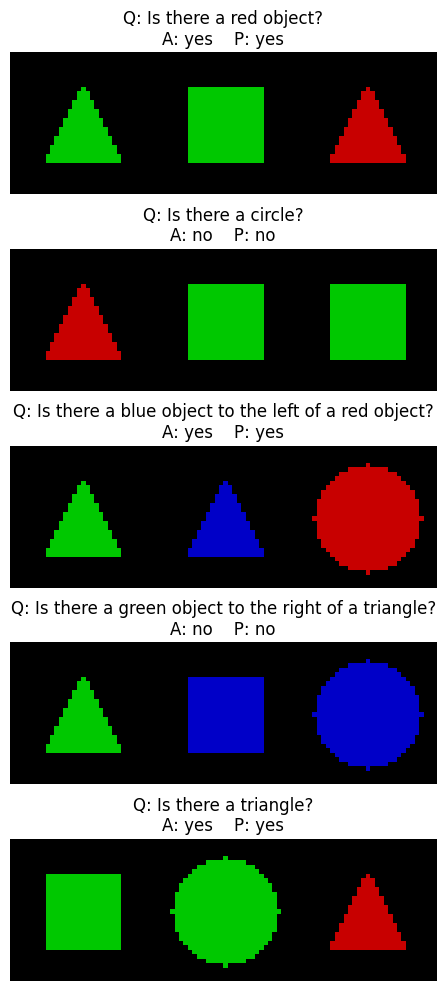

In [9]:
model.eval()

def get_answer(model, image: torch.Tensor, question: str):
    with torch.no_grad():
        outputs = model({'image': image.unsqueeze(0), 'question': [question], 'answer': [None]})
    return outputs['pred_answers'][0]


plt.figure(figsize=(5, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    image, question, answer = test_dataset[i]['image'], test_dataset[i]['question'], test_dataset[i]['answer']
    answer = 'yes' if answer else 'no'
    pred_answer = get_answer(model, image, question)
    plt.imshow(image.permute(1, 2, 0).numpy()[..., ::-1] * 0.5 + 0.5)
    plt.title(f'Q: {question}\nA: {answer}    P: {pred_answer}')
    plt.axis('off')

plt.tight_layout()
plt.show()